# Time Series Prediction with Recurrent Neural Networks

##### Data Set:

Daily Apple stocks information from January 2011 - August 2017
 - provides opening, closing, high and low price for the day

##### Load required modules

In [1]:
import os
import numpy
import math
import matplotlib.pyplot as plt

from pandas import DataFrame, concat, read_csv

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Activation, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


##### Fix random seed for reproducibility

In [2]:
import numpy
numpy.random.seed(123)

In [3]:
dataframe = read_csv('apple_share_price.csv')
dataframe.head(5)

Date    Open    High     Low   Close    Volume
0  11-Aug-17  156.60  158.57  156.07  157.48  26257096
1  10-Aug-17  159.90  160.00  154.63  155.32  40804273
2   9-Aug-17  159.26  161.27  159.11  161.06  26131530
3   8-Aug-17  158.60  161.83  158.27  160.08  36205896
4   7-Aug-17  157.06  158.92  156.67  158.81  21870321

In [4]:
dataframe.tail(5)

Date   Open   High    Low  Close     Volume
1659  7-Jan-11  47.71  48.05  47.41  48.02   77982212
1660  6-Jan-11  47.82  47.89  47.56  47.68   75106626
1661  5-Jan-11  47.08  47.76  47.07  47.71   63879193
1662  4-Jan-11  47.49  47.50  46.88  47.33   77337001
1663  3-Jan-11  46.52  47.18  46.41  47.08  111280407

In [5]:
# Re-reading with only the column of interest
dataframe = read_csv('apple_share_price.csv',  usecols=[4])

#Reversing the index
dataframe = dataframe.reindex(index = dataframe.index[::-1])

##### Extract the NumPy array from the dataframe and convert the integer values to floating point values.

In [6]:
dataset = dataframe.values
dataset = dataset.astype('float32')

##### Plot the dataset

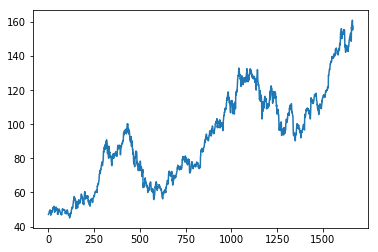

In [7]:
%matplotlib inline
plt.plot(dataset)
plt.show()

##### Split the data into train and test

    Note: With time series data, the sequence is important. So split the ordered dataset into train and test.


In [8]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

1248 416


##### Normalize the Data
Normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train)

train_Scal = scaler.transform(train)

test_Scal = scaler.transform(test)

In [10]:
print (train_Scal[:10])

[[0.0230813 ]
 [0.02592385]
 [0.03024447]
 [0.02990335]
 [0.03376919]
 [0.04400223]
 [0.04275155]
 [0.0471859 ]
 [0.04923254]
 [0.05378056]]


### Preparing the data for our Recurrent Neural Networks

#### Define function to provide lookback values from previous steps

In [11]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back = 1):       
    y = DataFrame(dataset)
    X = [y.shift(i) for i in range(1, look_back+1)]
    X = concat(X, axis=1)
    X.fillna(0, inplace = True)
    return X.values, y.values

- We'll use a constant look back period (#time steps) while trying different variants
- This will help us compare

In [12]:
# Define time steps to look back into
look_back = 10

In [13]:
trainX, trainY = create_dataset(train_Scal, look_back=look_back)
testX, testY = create_dataset(test_Scal, look_back= look_back)

##### Prepare the train and test datasets 
Using create_dataset function

In [14]:
trainX.shape, testX.shape

((1248, 10), (416, 10))

In [15]:
len(dataframe)

1664

#### The RNN networks expect the input data (X) to be provided with a specific array structure in the form 

[samples, time steps, features].

In [16]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [17]:
trainX.shape

(1248, 10, 1)

## Using plain vanilla RNNs

###### Design and fit our RNN network for this problem.

The network has 

- A hidden layer with 5 RNN cells or neurons, and 
- An output layer that makes a single value prediction. 
- The default sigmoid activation function is used for the LSTM blocks. 
- The network is trained for 100 epochs and a batch size of 1 is used.

In [18]:
num_neurons = 64

##### Create the RNN  network

In [19]:
look_back

10

In [20]:
?SimpleRNN

In [21]:
model = Sequential()
#model.add(SimpleRNN(num_neurons, input_shape=(look_back, 1), activation="tanh", dropout=0.2))
model.add(SimpleRNN(num_neurons, input_shape=(look_back, 1)))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


##### Compile the model

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
trainX.shape, trainY.shape

((1248, 10, 1), (1248, 1))

In [25]:
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_split=0.1)

Train on 1123 samples, validate on 125 samples
Epoch 1/5
 - 4s - loss: 0.0025 - val_loss: 0.0038
Epoch 2/5
 - 3s - loss: 0.0016 - val_loss: 0.0018
Epoch 3/5
 - 3s - loss: 9.8412e-04 - val_loss: 8.4347e-04
Epoch 4/5
 - 2s - loss: 8.3079e-04 - val_loss: 7.6395e-04
Epoch 5/5
 - 2s - loss: 8.6652e-04 - val_loss: 9.3113e-04


##### Estimate the performance of the model

In [26]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.03 RMSE)
Test Score: 0.01 MSE (0.07 RMSE)


##### Predictions using the built model

In [27]:
trainPredict_Scal = model.predict(trainX)
testPredict_Scal = model.predict(testX)

Invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data 

In [28]:
trainPredict = scaler.inverse_transform(trainPredict_Scal)
testPredict = scaler.inverse_transform(testPredict_Scal)

#### Preparte and plot the data



In [29]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+look_back:, :] = testPredict[look_back:]

<IPython.core.display.Javascript object>


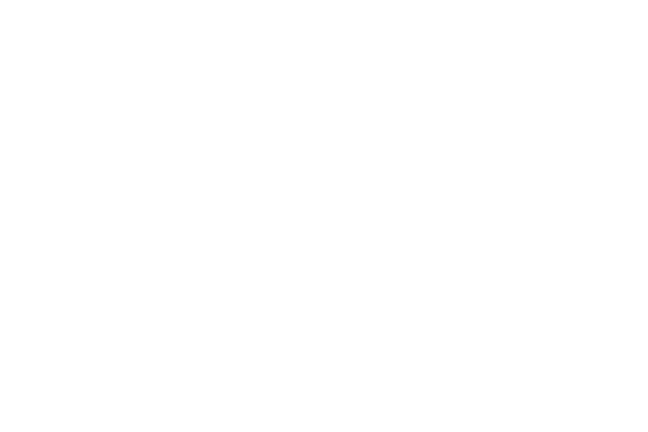

<IPython.core.display.Javascript object>


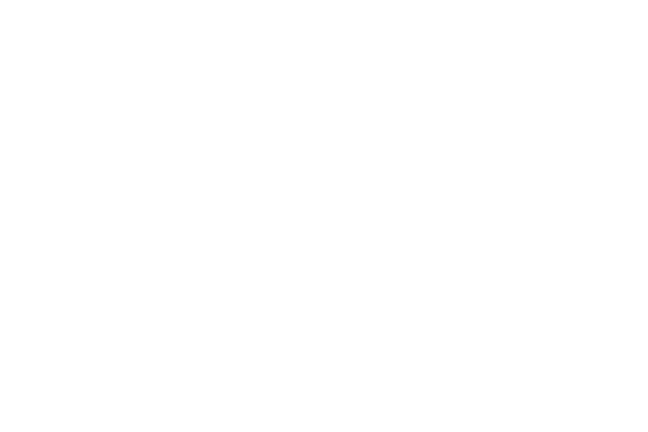

In [30]:
%matplotlib notebook

# plot baseline and predictions
plt.plot(dataset)
plt.plot(testPredictPlot)
plt.show()

## Using LSTMs

In [31]:
num_neurons

64

##### Create the LSTM network

In [32]:
look_back

10

In [33]:
model_lstm = Sequential()
#model_lstm.add(LSTM(num_neurons, input_shape=(look_back, 1), dropout=0.2))
model_lstm.add(LSTM(num_neurons, input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.add(Activation("linear"))

In [34]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


##### Compile the LSTM network

In [35]:
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

##### Fit the LSTM network

In [36]:
trainX.shape, trainY.shape

((1248, 10, 1), (1248, 1))

In [37]:
model_lstm.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_split=0.1)

Train on 1123 samples, validate on 125 samples
Epoch 1/10
 - 8s - loss: 0.0035 - val_loss: 0.0020
Epoch 2/10
 - 7s - loss: 0.0013 - val_loss: 0.0041
Epoch 3/10
 - 7s - loss: 0.0013 - val_loss: 0.0017
Epoch 4/10
 - 7s - loss: 0.0012 - val_loss: 0.0014
Epoch 5/10
 - 7s - loss: 0.0011 - val_loss: 0.0017
Epoch 6/10
 - 8s - loss: 0.0012 - val_loss: 0.0018
Epoch 7/10
 - 7s - loss: 0.0011 - val_loss: 0.0021
Epoch 8/10
 - 7s - loss: 0.0012 - val_loss: 0.0018
Epoch 9/10
 - 7s - loss: 9.2691e-04 - val_loss: 0.0030
Epoch 10/10
 - 7s - loss: 9.7828e-04 - val_loss: 0.0033


##### Estimate the performance of the model

In [38]:
# Estimate model performance
trainScore = model_lstm.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model_lstm.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.03 RMSE)
Test Score: 0.00 MSE (0.07 RMSE)


##### Predictions using the built model

In [39]:
trainPredict_Scal = model.predict(trainX)
testPredict_Scal = model.predict(testX)

Invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data 

In [40]:
trainPredict = scaler.inverse_transform(trainPredict_Scal)

testPredict = scaler.inverse_transform(testPredict_Scal)

#### Preparte and plot the data



In [41]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+look_back:, :] = testPredict[look_back:]

<IPython.core.display.Javascript object>


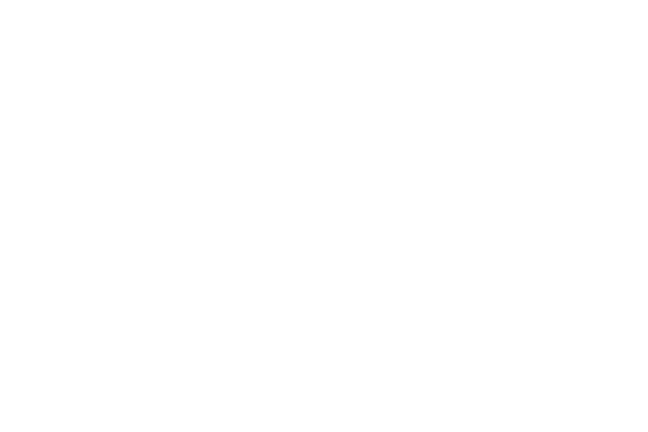

In [42]:
%matplotlib notebook

# plot baseline and predictions
plt.plot(dataset, label =  "Original data")
plt.plot(testPredictPlot, label = "Predicted test")
plt.show()

## Trying out GRUs

##### Create the GRU network

In [43]:
num_neurons

64

In [44]:
model = Sequential()
model.add(GRU(num_neurons, input_shape=(look_back,1)))
model.add(Dense(1))
model.add(Activation("linear"))

##### Compile the LSTM network


In [45]:
model.compile(loss='mean_squared_error', optimizer='adam')

Model Summary 

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                12672     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________


##### Fit the LSTM network

In [47]:
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2,validation_split=0.1)

Train on 1123 samples, validate on 125 samples
Epoch 1/20
 - 7s - loss: 0.0050 - val_loss: 0.0045
Epoch 2/20
 - 6s - loss: 0.0015 - val_loss: 0.0017
Epoch 3/20
 - 6s - loss: 0.0014 - val_loss: 0.0023
Epoch 4/20
 - 6s - loss: 0.0012 - val_loss: 0.0026
Epoch 5/20
 - 6s - loss: 0.0012 - val_loss: 0.0013
Epoch 6/20
 - 6s - loss: 0.0010 - val_loss: 0.0013
Epoch 7/20
 - 6s - loss: 9.4188e-04 - val_loss: 0.0015
Epoch 8/20
 - 6s - loss: 8.4493e-04 - val_loss: 0.0012
Epoch 9/20
 - 6s - loss: 7.5114e-04 - val_loss: 0.0011
Epoch 10/20
 - 6s - loss: 6.7463e-04 - val_loss: 0.0011
Epoch 11/20
 - 7s - loss: 6.3809e-04 - val_loss: 9.8382e-04
Epoch 12/20
 - 6s - loss: 5.8352e-04 - val_loss: 0.0013
Epoch 13/20
 - 6s - loss: 5.1967e-04 - val_loss: 0.0010
Epoch 14/20
 - 6s - loss: 4.9653e-04 - val_loss: 0.0012
Epoch 15/20
 - 6s - loss: 4.6520e-04 - val_loss: 0.0015
Epoch 16/20
 - 7s - loss: 4.6458e-04 - val_loss: 0.0011
Epoch 17/20
 - 7s - loss: 4.7747e-04 - val_loss: 8.0103e-04
Epoch 18/20
 - 6s - loss: 

##### Estimate the performance of the model

In [48]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.05 RMSE)


##### Predictions using the built model

In [49]:
trainPredict_Scal = model.predict(trainX)
testPredict_Scal = model.predict(testX)

##### Invert the predictions back to same units as the original data 

In [50]:
trainPredict = scaler.inverse_transform(trainPredict_Scal)
testPredict = scaler.inverse_transform(testPredict_Scal)

#### Preparte and plot the data



In [51]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+look_back:, :] = testPredict[look_back:]

<IPython.core.display.Javascript object>


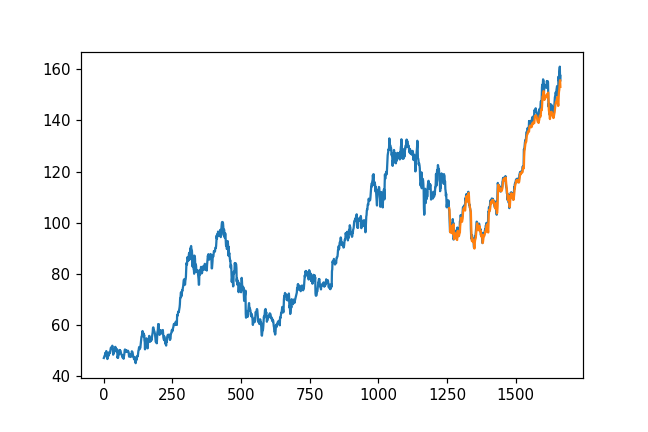

In [52]:
%matplotlib notebook

# plot baseline and predictions
plt.plot(dataset)
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
